## 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
  * For consistency, the dataset should have 1000 samples and a random_state=42.
  * Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
X_np, y_np = make_moons(n_samples=1000, random_state=42)

In [3]:
X_np[:5]

array([[ 0.00872719,  0.36817352],
       [ 0.921384  , -0.49690497],
       [ 0.94022577, -0.49821192],
       [ 0.46587532, -0.34540571],
       [-0.85041204,  0.52611726]])

In [4]:
set(y_np)

{0, 1}

In [5]:
X = torch.from_numpy(X_np).type(torch.float32).to('cuda')
y = torch.from_numpy(y_np).type(torch.float32).unsqueeze(dim=1).to('cuda')

In [6]:
X[:5]

tensor([[ 0.0087,  0.3682],
        [ 0.9214, -0.4969],
        [ 0.9402, -0.4982],
        [ 0.4659, -0.3454],
        [-0.8504,  0.5261]], device='cuda:0')

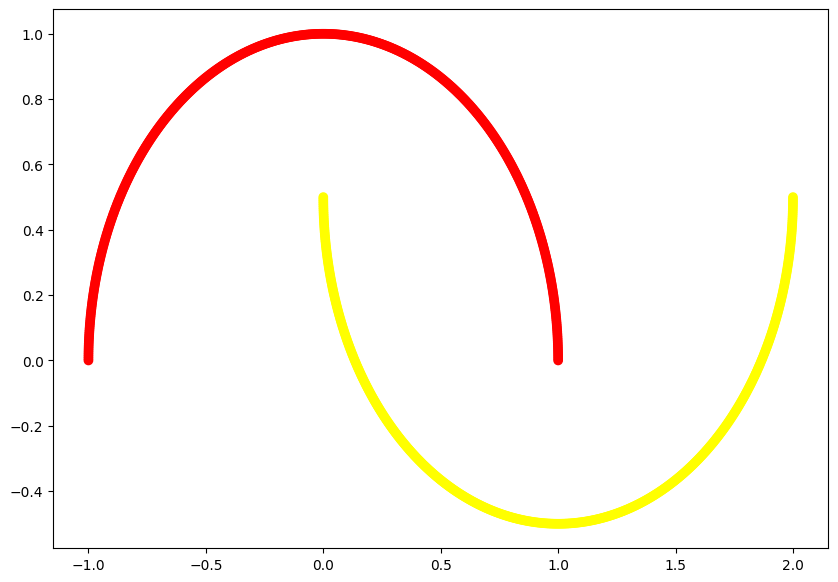

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X.cpu()[:, 0], X.cpu()[:, 1], c=y.cpu(), cmap='autumn')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [9]:
class MoonClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        x = self.sigmoid(x)
        return x

In [10]:
model = MoonClassifier().to('cuda')

In [11]:
model.eval()
with torch.inference_mode():
    first_preds = model(X_test)
first_preds[:5]

tensor([[0.4873],
        [0.4918],
        [0.4909],
        [0.4915],
        [0.4958]], device='cuda:0')

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [12]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [13]:
def accuracy_fn(preds, labels):
    correct = (preds == labels).sum()
    return correct / len(labels)

In [14]:
accuracy_fn(first_preds.round(), y_test)

tensor(0.5000, device='cuda:0')

In [15]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    pred_step = model(X_train)
    loss = loss_fn(pred_step, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model.eval()
        pred_step_test = model(X_test)
        loss = loss_fn(pred_step_test, y_test)
        accuracy = accuracy_fn(torch.round(pred_step_test), y_test) * 100
        
        print(f"Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}%")

Epoch: 0, Loss: 0.6862698197364807, Accuracy: 74.0%
Epoch: 10, Loss: 0.5978761315345764, Accuracy: 78.5%
Epoch: 20, Loss: 0.4465956687927246, Accuracy: 79.0%
Epoch: 30, Loss: 0.3196912407875061, Accuracy: 81.0%
Epoch: 40, Loss: 0.25224417448043823, Accuracy: 89.5%
Epoch: 50, Loss: 0.22847360372543335, Accuracy: 91.0%
Epoch: 60, Loss: 0.21494229137897491, Accuracy: 91.0%
Epoch: 70, Loss: 0.20921018719673157, Accuracy: 91.0%
Epoch: 80, Loss: 0.19716140627861023, Accuracy: 91.5%
Epoch: 90, Loss: 0.17979009449481964, Accuracy: 91.99999237060547%
Epoch: 100, Loss: 0.15287987887859344, Accuracy: 94.0%
Epoch: 110, Loss: 0.11471248418092728, Accuracy: 96.5%
Epoch: 120, Loss: 0.07046525925397873, Accuracy: 98.99999237060547%
Epoch: 130, Loss: 0.03789915144443512, Accuracy: 100.0%
Epoch: 140, Loss: 0.02090686745941639, Accuracy: 100.0%
Epoch: 150, Loss: 0.012473970651626587, Accuracy: 100.0%
Epoch: 160, Loss: 0.008291131816804409, Accuracy: 100.0%
Epoch: 170, Loss: 0.006034938618540764, Accuracy

## 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [16]:
def plot_decision_boundary(model: nn.Module, X: torch.Tensor, y: torch.Tensor, last_activation=lambda x: x):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    # mashgrid creates all possible coordinates from a combination of linspaces

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    # ravel flattens the tensor into 1 dimension
    # column stack stacks the arrays in 2 different columns
    # (creates a matrix of shape (len(xx) x 2), len(xx) == len(yy)

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        # y_pred = torch.round(y_logits)
        y_pred = torch.round(last_activation(y_logits))
        # y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


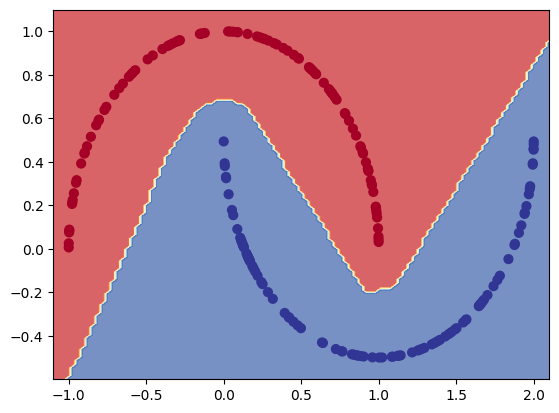

In [17]:
plot_decision_boundary(model, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the ML cheatsheet website for the formula.

In [18]:
def custom_tanh(z: torch.Tensor) -> torch.Tensor:
    return (torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z))

In [19]:
test_tensor = torch.rand(4)
test_tensor

tensor([0.9789, 0.0072, 0.1961, 0.7661])

In [20]:
torch.tanh(test_tensor)

tensor([0.7526, 0.0072, 0.1936, 0.6447])

In [21]:
custom_tanh(test_tensor)

tensor([0.7526, 0.0072, 0.1936, 0.6447])

## 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
  * Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

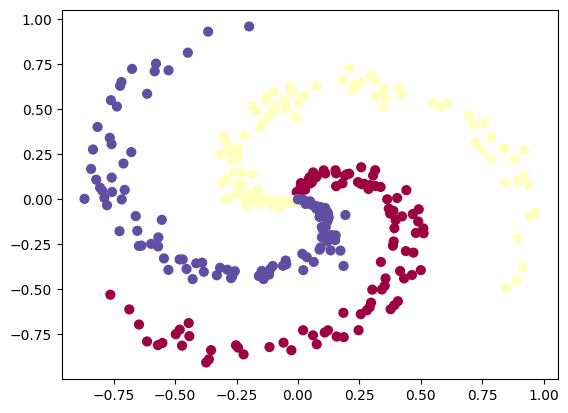

In [22]:
# Data creation funcion CS231n
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [23]:
X_tensor = torch.from_numpy(X).type(torch.float32).to('cuda')
y_tensor = torch.from_numpy(y).type(torch.LongTensor).to('cuda')

In [24]:
X_tensor[:5]

tensor([[ 0.0000,  0.0000],
        [ 0.0010,  0.0100],
        [ 0.0027,  0.0200],
        [-0.0013,  0.0303],
        [-0.0049,  0.0401]], device='cuda:0')

In [25]:
y_tensor[:5]

tensor([0, 0, 0, 0, 0], device='cuda:0')

In [26]:
set(y_tensor.tolist())

{0, 1, 2}

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([240, 2]),
 torch.Size([60, 2]),
 torch.Size([240]),
 torch.Size([60]))

In [28]:
class SpiralModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        return x

In [29]:
model_multi = SpiralModel().to('cuda')
model_multi

SpiralModel(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)

In [30]:
loss_fn = torch.nn.CrossEntropyLoss() # this function includes softmax
optimizer = torch.optim.Adam(model_multi.parameters(), lr=0.01)

In [31]:
model_multi.eval()
with torch.inference_mode():
    first_preds = model_multi(X_test)
first_preds[:5]

tensor([[ 0.1289, -0.3177, -0.0049],
        [ 0.1861, -0.3343,  0.0348],
        [ 0.1512, -0.2946, -0.0135],
        [ 0.1305, -0.3122, -0.0063],
        [ 0.1220, -0.3343, -0.0076]], device='cuda:0')

In [32]:
torch.softmax(first_preds[:5], dim=1).argmax(dim=1)

tensor([0, 0, 0, 0, 0], device='cuda:0')

In [33]:
epochs = 1000
for epoch in range(epochs):
    model_multi.train()
    pred_step = model_multi(X_train)
    loss = loss_fn(pred_step, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model_multi.eval()
        with torch.inference_mode():
            pred_test_logits = model_multi(X_test)
            pred_labels = torch.softmax(pred_test_logits, dim=1).argmax(dim=1)
            
            loss = loss_fn(pred_test_logits, y_test)
            accuracy = accuracy_fn(pred_labels, y_test) * 100
            
            print(f"Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}%")
        

Epoch: 0, Loss: 1.0845, Accuracy: 36.6667%
Epoch: 10, Loss: 1.0789, Accuracy: 36.6667%
Epoch: 20, Loss: 1.0055, Accuracy: 48.3333%
Epoch: 30, Loss: 0.9154, Accuracy: 50.0000%
Epoch: 40, Loss: 0.8225, Accuracy: 55.0000%
Epoch: 50, Loss: 0.7398, Accuracy: 51.6667%
Epoch: 60, Loss: 0.6863, Accuracy: 55.0000%
Epoch: 70, Loss: 0.6394, Accuracy: 60.0000%
Epoch: 80, Loss: 0.5905, Accuracy: 66.6667%
Epoch: 90, Loss: 0.5326, Accuracy: 70.0000%
Epoch: 100, Loss: 0.4757, Accuracy: 75.0000%
Epoch: 110, Loss: 0.4250, Accuracy: 81.6667%
Epoch: 120, Loss: 0.3713, Accuracy: 88.3333%
Epoch: 130, Loss: 0.3308, Accuracy: 88.3333%
Epoch: 140, Loss: 0.2985, Accuracy: 90.0000%
Epoch: 150, Loss: 0.2818, Accuracy: 90.0000%
Epoch: 160, Loss: 0.2678, Accuracy: 90.0000%
Epoch: 170, Loss: 0.2568, Accuracy: 93.3333%
Epoch: 180, Loss: 0.2468, Accuracy: 93.3333%
Epoch: 190, Loss: 0.2384, Accuracy: 95.0000%
Epoch: 200, Loss: 0.2309, Accuracy: 96.6667%
Epoch: 210, Loss: 0.2239, Accuracy: 96.6667%
Epoch: 220, Loss: 0.2

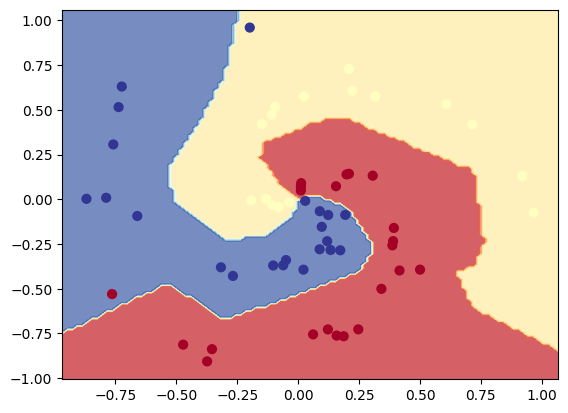

In [34]:
plot_decision_boundary(model_multi, X_test, y_test)